# Table of Contents

1. [Introduction](#introduction)
2. [Notebook settings](#notebook-settings)
3. [Dependencies](#dependencies)
4. [Data Cleaning](#data-cleaning)
    1. [Geopy: Usage and findings](#geopy-usage-and-findings)
    2. [New Dataset Outcome](#new-dataset-outcome)
    3. [Data Loading, Cleaning and Transforming Main dataset](#data-loading-cleaning-and-transforming-main-dataset)
        - [Data validation: duplicates and Nan records](#data-validation-duplicates-and-nan-records)
        - [Data Transformation: 'Age' feature investigation](#data-transformation-age-feature-investigation)
    4. [Data Loading, Cleaning and Transforming Additional dataset](#data-loading-cleaning-and-transforming-additional-dataset)
5. [Conclusion About Data Cleaning and Validation processes](#conclusion-about-data-cleaning-and-validation-processes)
6. [ EDA - Exploratory Data Analysis](#eda---exploratory-data-analysis)
    1. [Objective and Analysis goal](#objective-and-analysis-goal)
    2. [Data inconsistency finding](#data-inconsistency-finding)
    3. [Demographic analysis: Racial group](#demographic-analysis-racial-group)
    5. [Exploring events locations](#exploring-events-locations)
        - [Geographical US map with event locations](#geographical-us-map-with-event-locations)
    6. [Targeted racial groups by regions](#targeted-racial-groups-by-regions)
    7. ['Age' feature and group analysis](#'age'-feature-and-group-analysis)
    8. [Analysis for top 3 most dangerous States by age group - 2015 to 2017](#analysis-for-top-3-most-dangerous-states-by-age-group---2015-to-2017)
7. [EDA Conclusion](#eda-conclusion)
8. [Project Conclusion](#project-conclusion)

# Introduction

The goal of this project is to analyze the Fatal Police Shootings dataset, between 2015 and 2017. This has been a national issue since the 20th century. The public safety of U.S. citizens is a typical argument to justify the controversially high number of fatal shootings. This analysis is interesting as this is an issue that is common to many countries and some approaches here can probably be applied to other datasets.
Therefore, to perform this analysis, I will use concepts from Data Visualization & Data Analysis.

# Notebook settings

In [1]:
%load_ext pycodestyle_magic
#%reload_ext pycodestyle_magic
%pycodestyle_on
%flake8_on
%flake8_on --max_line_length 80
%matplotlib inline

# Dependencies

Below are the libraries used in this project:
1. First are the functions developed to be used within the code &
2. The libraries required to run the project

In [2]:
from assets.utils.functions import (
    get_geocodes,
    classify_age_bins,
    get_year_data,
    get_grouped_data,
    plot_percentage,
    process_year_data
)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from geopy.geocoders import Nominatim
import time as time

# Data cleaning

In [4]:
int_df = pd.read_csv("./assets/data/database.csv")
int_df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


In [5]:
print(int_df.shape)

(2142, 14)


In [6]:
# Clean columns
for col in int_df.columns:
    # Check if the column is of object type
    if int_df[col].dtype == 'object':
        # Remove leading and trailing spaces from the column
        int_df[col] = int_df[col].str.strip()

# Geopy: Usage and findings

Since one of the goals of this analysis is to check the locations (meaning cities, states), I decided to use the Geopy library to get the latitude and longitude of such locations, as I think this can be a good approach to map the individual events of the dataset provided, for futher visualization.
Geopy is a Python library that provides easy access to various geocoding services and other geographical data APIs.</br> As per the code below, to get the latitude and longitude using Geopy, took a bit of time (~41 mins).

In [7]:
# Geopy: to be used just to create a new dataset
int_df = get_geocodes(int_df)

# New Dataset Outcome

Due to the amount of time running Geopy, it was decided to save the results in an additional CSV file, named `geocordsdb.csv`. This will avoid running the Geopy whenever someone wants to use the dataset. This CSV file will be used to perform the cleaning and respective EDA processes, since it will have all the features and observations inherited from the main dataset, named `database.csv`. Also good reasons to create a new dataset could be:<br/>

1. **Preservation of Original Data:** By creating a new dataset, you preserve the integrity of the original data. If you were to add new columns (lat and lon) to the original dataset, you would be altering the original data, which may not be desirable if you need to maintain the integrity of the original dataset for future analyses or comparisons.
2. **Traceability and Reproducibility:** Keeping the original dataset unchanged allows for better traceability and reproducibility of your analyses. If you ever need to backtrack or reproduce your analysis, having a separate dataset with the added latitude and longitude values ensures that you can always refer back to the original dataset without any modifications.
3. **Flexibility and Modularity:** Creating a new dataset for analytical purposes provides flexibility and modularity in your analysis pipeline. You can easily switch between different versions of the dataset or apply different analyses without affecting the original data. It also allows for easier sharing and collaboration, as you can provide others with the original dataset along with any derived datasets for analysis.
4. **Data Integrity and Consistency:** Separating the original dataset from the derived dataset helps maintain data integrity and consistency. If there are any issues or discrepancies in the derived data (e.g., inaccuracies in the geocoding process), they won't affect the original dataset, and you can address them separately without impacting the original data.

In [9]:
int_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2142 non-null   int64  
 1   name                     2123 non-null   object 
 2   date                     2142 non-null   object 
 3   manner_of_death          2142 non-null   object 
 4   armed                    2136 non-null   object 
 5   age                      2099 non-null   float64
 6   gender                   2141 non-null   object 
 7   race                     2039 non-null   object 
 8   city                     2142 non-null   object 
 9   state                    2142 non-null   object 
 10  signs_of_mental_illness  2142 non-null   bool   
 11  threat_level             2142 non-null   object 
 12  flee                     2106 non-null   object 
 13  body_camera              2142 non-null   bool   
 14  latitude                

In [10]:
int_df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,latitude,longitude
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,47.215094,-123.100706
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,45.491518,-122.869420
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,37.692236,-97.337545
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,37.779259,-122.419329
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,40.377217,-104.697763


In [11]:
# Get the latitude and longitude possible Nan records
nan_records = int_df[int_df['latitude'].isna() | int_df['longitude'].isna()]
print(nan_records.to_string())

        id                        name        date manner_of_death    armed   age gender race                            city state  signs_of_mental_illness  threat_level         flee  body_camera  latitude  longitude
156    196            Shaquille Barrow  2015-03-02            shot      gun  20.0      M    B                          Joilet    IL                    False         other         Foot        False       NaN        NaN
211    531               Justin Fowler  2015-03-20            shot      gun  24.0      M    N                      Red Valley    AZ                    False        attack          Car        False       NaN        NaN
412    518  Alejandro Campos Fernandez  2015-06-06            shot      gun  45.0      M    H                    Watsonsville    CA                    False        attack         Foot        False       NaN        NaN
766    900                   Kevin Lau  2015-10-11            shot      gun  44.0      M    A                   Lakes Charles   

### Fixing city names and geting latitudes and longitudes

The output above indicates that some records have NaN values for latitude and longitude. After examining the cities, it becomes apparent that these discrepancies stem from spelling errors in the city names.<br/> As this issue affects only 12 cities, the names will be manually corrected along with their corresponding latitude and longitude values. However, if there were numerous discrepancies, the geopy library could be utilized to search for and obtain the corrected latitude and longitude coordinates, by passing the new dataframe corrected as to be read by geopy.

In [12]:
# Correcting city names
int_df.loc[:, 'city'] = int_df['city'].replace({
    'Joilet': 'Joliet',
    'Red Valley': 'Red Valley',
    'Watsonsville': 'Watsonville',
    'Lakes Charles': 'Lake Charles',
    'Manchester': 'Manchester Township',
    'East Berstadt': 'East Bernstadt',
    'Jacksonsville': 'Jacksonville',
    'McKinneyville': 'Mckinleyville',
    'Weeki Wachi': 'Weeki Wachee',
    'Muckleshoot Indian Reservation': 'Muckleshoot',
    'Simpsonsville': 'Simpsonville'})

# Write the DataFrame back to the file
int_df.to_csv("./assets/data/geocordsdb.csv", index=False)

In [13]:
# Update the dataset with lat and long
new_data = pd.DataFrame({
    'city': ['Joliet', 'Red Valley', 'Watsonville', 'Jacksonville',
             'Lake Charles', 'Manchester Township', 'East Bernstadt',
             'Mckinleyville', 'Weeki Wachee', 'Muckleshoot', 'Simpsonville'],
    'state': ['IL', 'AZ', 'CA', 'FL', 'LA', 'NJ', 'KY', 'CA',
              'FL', 'WA', 'KY'],
    'latitude': [41.527154, 35.915556, 36.909277, 30.332184, 30.228453,
                 39.950983, 37.190779, 40.875833, 28.5155513,
                 47.2623, 38.231186],
    'longitude': [-88.08241, -109.029167, -121.752907, -81.655651, -93.187966,
                  -74.360713, -84.145676, -124.083056, -82.57287689,
                  -122.1467, -85.354797]
})

# Create a dictionary from the new data for easy lookup
new_data_dict = new_data.set_index(['city', 'state']).T.to_dict('list')

# Update the latitude and longitude in the original DataFrame
for index, row in int_df.iterrows():
    if (row['city'], row['state']) in new_data_dict:
        lat = new_data_dict[(row['city'], row['state'])][0]
        long = new_data_dict[(row['city'], row['state'])][1]
        int_df.loc[index, 'latitude'] = lat
        int_df.loc[index, 'longitude'] = long

# Save the updated DataFrame to the file
int_df.to_csv("./assets/data/geocordsdb.csv", index=False)

# Data Loading, Cleaning and Transforming Main dataset

In [4]:
main_df = pd.read_csv("./assets/data/geocordsdb.csv", index_col='id')

In [5]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2142 entries, 3 to 2394
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     2123 non-null   object 
 1   date                     2142 non-null   object 
 2   manner_of_death          2142 non-null   object 
 3   armed                    2136 non-null   object 
 4   age                      2099 non-null   float64
 5   gender                   2141 non-null   object 
 6   race                     2039 non-null   object 
 7   city                     2142 non-null   object 
 8   state                    2142 non-null   object 
 9   signs_of_mental_illness  2142 non-null   bool   
 10  threat_level             2142 non-null   object 
 11  flee                     2106 non-null   object 
 12  body_camera              2142 non-null   bool   
 13  latitude                 2142 non-null   float64
 14  longitude                2142

As we can see, two more features were added being latitude and longitude. The original dataset has 14 features. The difference here is that `id` column was indexed.

In [6]:
main_df.describe()

,age,latitude,longitude
count,2099.000000,2142.000000,2142.000000
mean,36.484516,36.624621,-97.081480
std,12.874000,5.246377,16.679369
min,6.000000,19.622521,-157.941667
25%,26.000000,33.448437,-112.074141
50%,34.000000,36.134698,-94.365801
75%,45.000000,39.940335,-83.000707
max,86.000000,71.386517,-68.015458


In [7]:
# Check dataframe shape
print(main_df.shape)

(2142, 15)


In [8]:
# Check for duplicated IDs
unique_ids = main_df.index.nunique()
print("Nº of unique ids: ", unique_ids)

duplicated_ids = main_df[main_df.index.duplicated()]

if duplicated_ids.empty:
    print("No duplicated IDs found.")
else:
    print("Duplicated IDs found:")
    print(duplicated_ids)

Nº of unique ids:  2142
No duplicated IDs found.


# Data validation: duplicates and Nan records

In [9]:
# Check for duplicate rows (samples)
duplicate_samples = main_df[main_df.duplicated()]
print(duplicate_samples.to_string())

                     name        date manner_of_death armed   age gender race     city state  signs_of_mental_illness threat_level flee  body_camera   latitude  longitude
id                                                                                                                                                                        
2294  Jamake Cason Thomas  2017-02-03            shot   gun  22.0      M    B  Rowland    NC                    False       attack  Car        False  34.536552 -79.291431


Since one duplication was found, I decided to further explore the dataset, since homonym is a common issue in the real world, and although the finding above means that all features are duplicated for one individual, it is still possible that the dataset has other issues related to the samples.

In [10]:
# Check for duplicated names
duplicated_names = main_df[main_df['name'].duplicated(keep=False)].dropna()
duplicated_names_sorted = duplicated_names.sort_values(by='name')
print(duplicated_names_sorted.to_string())

                          name        date manner_of_death       armed   age gender race         city state  signs_of_mental_illness  threat_level         flee  body_camera   latitude  longitude
id                                                                                                                                                                                                
229              Brandon Jones  2015-03-19            shot     unarmed  18.0      M    B    Cleveland    OH                    False        attack  Not fleeing        False  41.499657 -81.693677
1991             Brandon Jones  2016-10-25            shot  toy weapon  25.0      M    W       Elkton    MD                     True        attack  Not fleeing        False  39.606507 -75.833093
1129  Daquan Antonio Westbrook  2015-12-24            shot         gun  18.0      M    B    Charlotte    NC                    False        attack  Not fleeing        False  35.227209 -80.843083
2158  Daquan Antonio West

### Duplicated names cleaning process

When checking by duplicate names there is a list of 10 exact names. Then, analyzing the other features is possible to see that although 8 individuals have the exact same names, the other features are different which does not allow to conclude that these are duplicated and therefore will be treated as unique. Other significant findings are listed below:

- One individual named _Daquan Antonio Westbrook_ (id=2158) has all the features equal, but the __threat_level__ is different. In this case, as this feature does not look consistent in identifying an individual, it was considered a duplicate record and properly dropped.

- The other individual named _Jamake Cason Thomas_ (id=2294) was identified as having duplicated records and properly dropped as well since it had all the features the same as per the above output provided.

In [11]:
# Get the indices of the rows to be dropped
ids_to_remove = main_df.index.isin([2158, 2294])
main_df = main_df.drop(main_df.index[ids_to_remove])
# Check if the rows have been dropped
print(main_df.index.isin([2158, 2294]).any(),
      "for ids 2158 and 2294.\n"
      "Records successfully removed.")

False for ids 2158 and 2294.
Records successfully removed.


### Checking for _Null_ names

In [12]:
# Check for Null names
null_names = main_df[main_df['name'].isnull()]
print(null_names.to_string())
print("#####################")
print("Nº of Null names: ", null_names.shape[0])

     name        date   manner_of_death         armed  age gender race             city state  signs_of_mental_illness  threat_level         flee  body_camera   latitude   longitude
id                                                                                                                                                                                   
1074  NaN  2015-12-10              shot           gun  NaN      M  NaN            Hemet    CA                    False        attack  Not fleeing        False  33.747520 -116.971968
1570  NaN  2016-05-26              shot           gun  NaN      M  NaN      San Antonio    TX                    False         other  Not fleeing        False  29.424600  -98.495141
1581  NaN  2016-05-26              shot         knife  NaN      F  NaN           Sneads    FL                    False         other  Not fleeing        False  30.707591  -84.924448
1584  NaN  2016-06-01              shot           gun  NaN      M  NaN          Phoenix   

### _Null_ names cleaning process

Since for 19 records the name is missing, but other features information are available, such as date, city, state, etc, it was decided to imput the missing names as _Unknown_ for these records. The reason is that looking at this dataset, although some names are missing, the killing still happened and the other features are available. Therefore, it is important to keep these records in the dataset.

In [13]:
# Inputing "Unknown" for Null names
main_df['name'].fillna('Unknown', inplace=True)

In [14]:
# Confirm if Null names have been replaced
null_names = main_df[main_df['name'].isnull()]
print(null_names.to_string())
print("Nº of Null names: ", null_names.shape[0])

Empty DataFrame
Columns: [name, date, manner_of_death, armed, age, gender, race, city, state, signs_of_mental_illness, threat_level, flee, body_camera, latitude, longitude]
Index: []
Nº of Null names:  0


### Investigation over other _Null_ feature records

In [15]:
# Check for missing values by columns
missing_values = main_df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
name                         0
date                         0
manner_of_death              0
armed                        6
age                         43
gender                       1
race                       103
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                        36
body_camera                  0
latitude                     0
longitude                    0
dtype: int64


#### _Null_ features findings
1. Features **"armed", "gender", "race", "flee"** are object datatype and the missing values will imputed as _undetermined_. Since these features are important to the analysis, it is important to keep these records in the dataset.
2. Feature **"age"** feature: will be kept as a float datatype and the missing values will be imputed as the mean of the feature. The analysis will be shown in the next steps.

In [16]:
# Inputing "undetermined" for Null values in the following columns:
columns_to_fill = ['armed', 'gender', 'race', 'flee']
for column in columns_to_fill:
    main_df[column].fillna(value='undetermined', inplace=True)

In [17]:
# Check for missing values by columns
missing_values = main_df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
name                        0
date                        0
manner_of_death             0
armed                       0
age                        43
gender                      0
race                        0
city                        0
state                       0
signs_of_mental_illness     0
threat_level                0
flee                        0
body_camera                 0
latitude                    0
longitude                   0
dtype: int64


# Data Transformation: 'Age' feature investigation
**Comparison between missing age and inputed mean age**

This approach aims to compare the distribution of the age feature before and after the imputation process. Therefore, the dataset was cloned in order to ease the visualization.</br>The idea is to check if the imputation process has significantly changed the distribution of the feature. So, a histogram plot was created to compare the distribution of the feature before and after the imputation process.

In [18]:
# Cloning main dataframe for testing
main_clone = main_df.copy()

In [19]:
# Checking total number of records
num_records = main_clone.shape[0]
print("Total number of records:", num_records)

# Checking number of missing ages
age_missing = main_clone['age'].isnull().sum()
print("Nº of missing ages: ", age_missing)

# Determining the average age of the victims
mean_age = main_clone['age'].mean()
print("Average value for ages: ", round(mean_age, 2))

# Percentage of imputed ages into the dataset
age_imputed = age_missing / num_records
print("Percentage of records having 'mean' value as imputed ages: ",
      round(age_imputed * 100, 2))

Total number of records: 2140
Nº of missing ages:  43
Average value for ages:  36.5
Percentage of records having 'mean' value as imputed ages:  2.01


In [20]:
# Inputing the mean age rounded to 1 decimal place for missing values
main_clone['age'].fillna(round(main_clone['age'].mean(), 1), inplace=True)

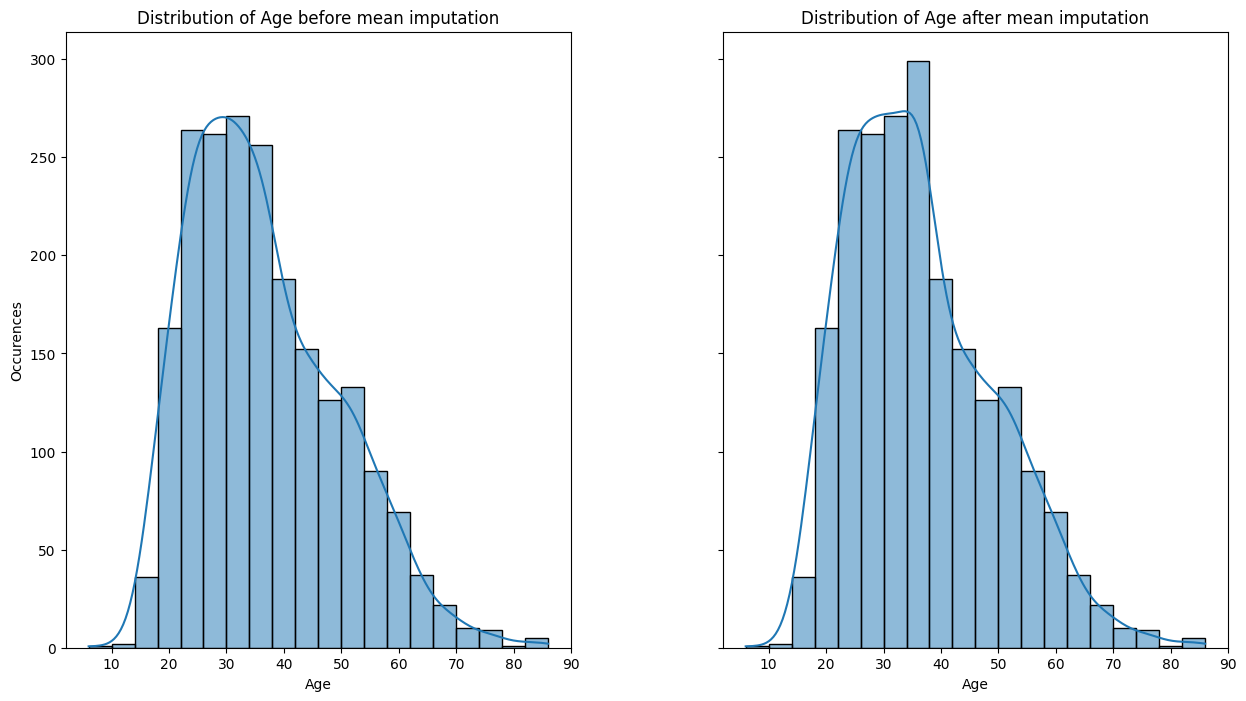

In [21]:
# Show the plot
fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

# First Plot:
sns.histplot(data=main_df['age'], bins=20, kde=True, ax=axes[0])

# Set labels and title
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Occurences')
axes[0].set_title('Distribution of Age before mean imputation')

# Second Plot:
sns.histplot(data=main_clone['age'], bins=20, kde=True, ax=axes[1])

# Set labels and title
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Occurences')
axes[1].set_title('Distribution of Age after mean imputation')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the plots
plt.show()

As seen, the distribution of the feature using the "mean" value will not change significantly after the imputation process, which will follow into the original dataset. We can see by looking at the bins between 30 and 40 a slight increase in the number of records, and as a consequence, the KDE curve is a bit more skewed to the right but this may not be too significant. Also to confirm the impact, the calculation previously made confirms that 2.01% of the population had "age" as an imputed value.

In [22]:
# Inputing the mean age rounded to 1 decimal place for missing values
main_df['age'].fillna(round(main_df['age'].mean(), 1), inplace=True)

In [23]:
# Checking number of missing ages
age_missing = main_df['age'].isnull().sum()
print("Nº of missing ages: ", age_missing)

Nº of missing ages:  0


In [24]:
# Confirming the numner of inputed records
average_age = main_df['age'] == 36.5
print("Nº of records with average age: ", average_age.sum())

Nº of records with average age:  43


We can confirm now that there are no missing values in the dataset.

In [25]:
# Check for missing values by columns
missing_values = main_df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
name                       0
date                       0
manner_of_death            0
armed                      0
age                        0
gender                     0
race                       0
city                       0
state                      0
signs_of_mental_illness    0
threat_level               0
flee                       0
body_camera                0
latitude                   0
longitude                  0
dtype: int64


### Converting data types

Since the dataset has been cleaned, it is important to convert the data types to the correct ones. By looking at the features below, `date` is the only one that needs conversion to datetime type.

In [26]:
print("Before conversion, date datatype is: ", main_df['date'].dtype)
main_df['date'] = pd.to_datetime(main_df['date'])
print("After conversion, date datatype is: ", main_df['date'].dtype)

Before conversion, date datatype is:  object
After conversion, date datatype is:  datetime64[ns]


In [27]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2140 entries, 3 to 2394
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   name                     2140 non-null   object        
 1   date                     2140 non-null   datetime64[ns]
 2   manner_of_death          2140 non-null   object        
 3   armed                    2140 non-null   object        
 4   age                      2140 non-null   float64       
 5   gender                   2140 non-null   object        
 6   race                     2140 non-null   object        
 7   city                     2140 non-null   object        
 8   state                    2140 non-null   object        
 9   signs_of_mental_illness  2140 non-null   bool          
 10  threat_level             2140 non-null   object        
 11  flee                     2140 non-null   object        
 12  body_camera              2140 non-null 

# Data Loading, Cleaning and Transforming Additional dataset

This dataset can be usefull for understanting the total population of USA, along with the states and regions. Then it can be useful to compare to the events occured that are the target of this analysis.

In [28]:
# Loading additional dataset
us_pop_df = pd.read_csv("./assets/data/sc-est2019-agesex-civ.csv")
us_pop_df.head()

,SUMLEV,REGION,DIVISION,STATE,NAME,SEX,AGE,ESTBASE2010_CIV,POPEST2010_CIV,POPEST2011_CIV,POPEST2012_CIV,POPEST2013_CIV,POPEST2014_CIV,POPEST2015_CIV,POPEST2016_CIV,POPEST2017_CIV,POPEST2018_CIV,POPEST2019_CIV
0,10,0,0,0,United States,0,0,3944160,3951430,3963092,3926570,3931258,3954787,3983981,3954773,3893990,3815343,3783052
1,10,0,0,0,United States,0,1,3978090,3957730,3966225,3977549,3942698,3948891,3973133,4002903,3972711,3908830,3829599
2,10,0,0,0,United States,0,2,4096939,4090621,3970654,3978925,3991740,3958711,3966321,3991349,4020045,3987032,3922044
3,10,0,0,0,United States,0,3,4119051,4111688,4101644,3981531,3991017,4005928,3974351,3982984,4006946,4033038,3998665
4,10,0,0,0,United States,0,4,4063186,4077346,4121488,4111490,3992502,4004032,4020292,3989750,3997280,4018719,4043323


Some features may not be useful for this analysis and it will be dropped.

In [29]:
us_pop_df = us_pop_df.drop(
    ['SUMLEV', 'DIVISION', 'ESTBASE2010_CIV',
     'POPEST2010_CIV', 'POPEST2011_CIV',
     'POPEST2012_CIV', 'POPEST2013_CIV',
     'POPEST2014_CIV', 'POPEST2018_CIV',
     'POPEST2019_CIV'], axis=1)

Since the dataset has SUM values for the features, I decided to drop them and analyze isolated values.

In [30]:
# Create a mask where all conditions are True
mask = (us_pop_df['REGION'] != 0) & (us_pop_df['REGION'] != 999) & \
       (us_pop_df['STATE'] != 0) & (us_pop_df['STATE'] != 999) & \
       (us_pop_df['SEX'] != 0) & (us_pop_df['SEX'] != 999) & \
       (us_pop_df['AGE'] != 999) & (us_pop_df['NAME'] != 'United States')\

# Apply the mask to the DataFrame
us_pop_df = us_pop_df[mask]

In [31]:
# Change feature names to lower case
us_pop_df.columns = us_pop_df.columns.str.lower()

In [32]:
# Renaming feature population names
us_pop_df = us_pop_df.rename(columns={
    'popest2015_civ': 'pop2015',
    'popest2016_civ': 'pop2016',
    'popest2017_civ': 'pop2017',
})

Checking the total population in US for the target years seems to be reasonable for further analysis and according to the population of the years to be analyzed.

In [33]:
# Recalculate the total population for each year
total_population_2015 = us_pop_df['pop2015'].sum()
total_population_2016 = us_pop_df['pop2016'].sum()
total_population_2017 = us_pop_df['pop2017'].sum()

print("US estimated population for 2015:", total_population_2015)
print("US estimated population for 2016:", total_population_2016)
print("US estimated population for 2017:", total_population_2017)

US estimated population for 2015: 319438649
US estimated population for 2016: 321738826
US estimated population for 2017: 323794924


# Conclusion About Data Cleaning and Validation processes
As the usage of Geopy library was used and one additional dataset to support further EDA processe, the data cleaning involved additional steps such as to correct city names and manually input latitudes and longitudes for these ones, since Geopy could not find it. It would be possible to rerun the library, howeve the running time is a bit over 41 minutes for 2140 records, considering there are duplicated city names. Also, the city names had some issues with the correct name. The fix was carried out since it was needed to get the correct latitudes and longitudes.
Some data transformation were carried out for some features with missing values and datatype conversion, such as:</br>

| Feature                            | Transformation                                       |
| ---------------------------------- | ---------------------------------------------------- |
| `name`                             | value added: `Unknown`                               |
| `armed`, `gender`, `race`, `flee`  | value added: `undetermined`                          |
| `age`                              | value added: `mean of the feature`, with impact of 2% over the total of ages. |
| `date`                             | converted to datetime type                           |


Related to the addiontal dataset, no further cleaning process was needed, but dropping unecessary features that I believe, would not be necessary for this project.

# EDA - Exploratory Data Analysis

The initial step involves obtaining an overview of the dataset and examining the behavior of each feature, including the distribution of the data. This helps to establish a foundation for investigating intriguing patterns or trends within the dataset.</br> Some features will not be plotted due to large amount of different data, such as `name`, `date` for obvious reasons.</br>
The feature `armed` will be plotted right below the sequence just for the top 10 most used weapons due to the large amount of different types.

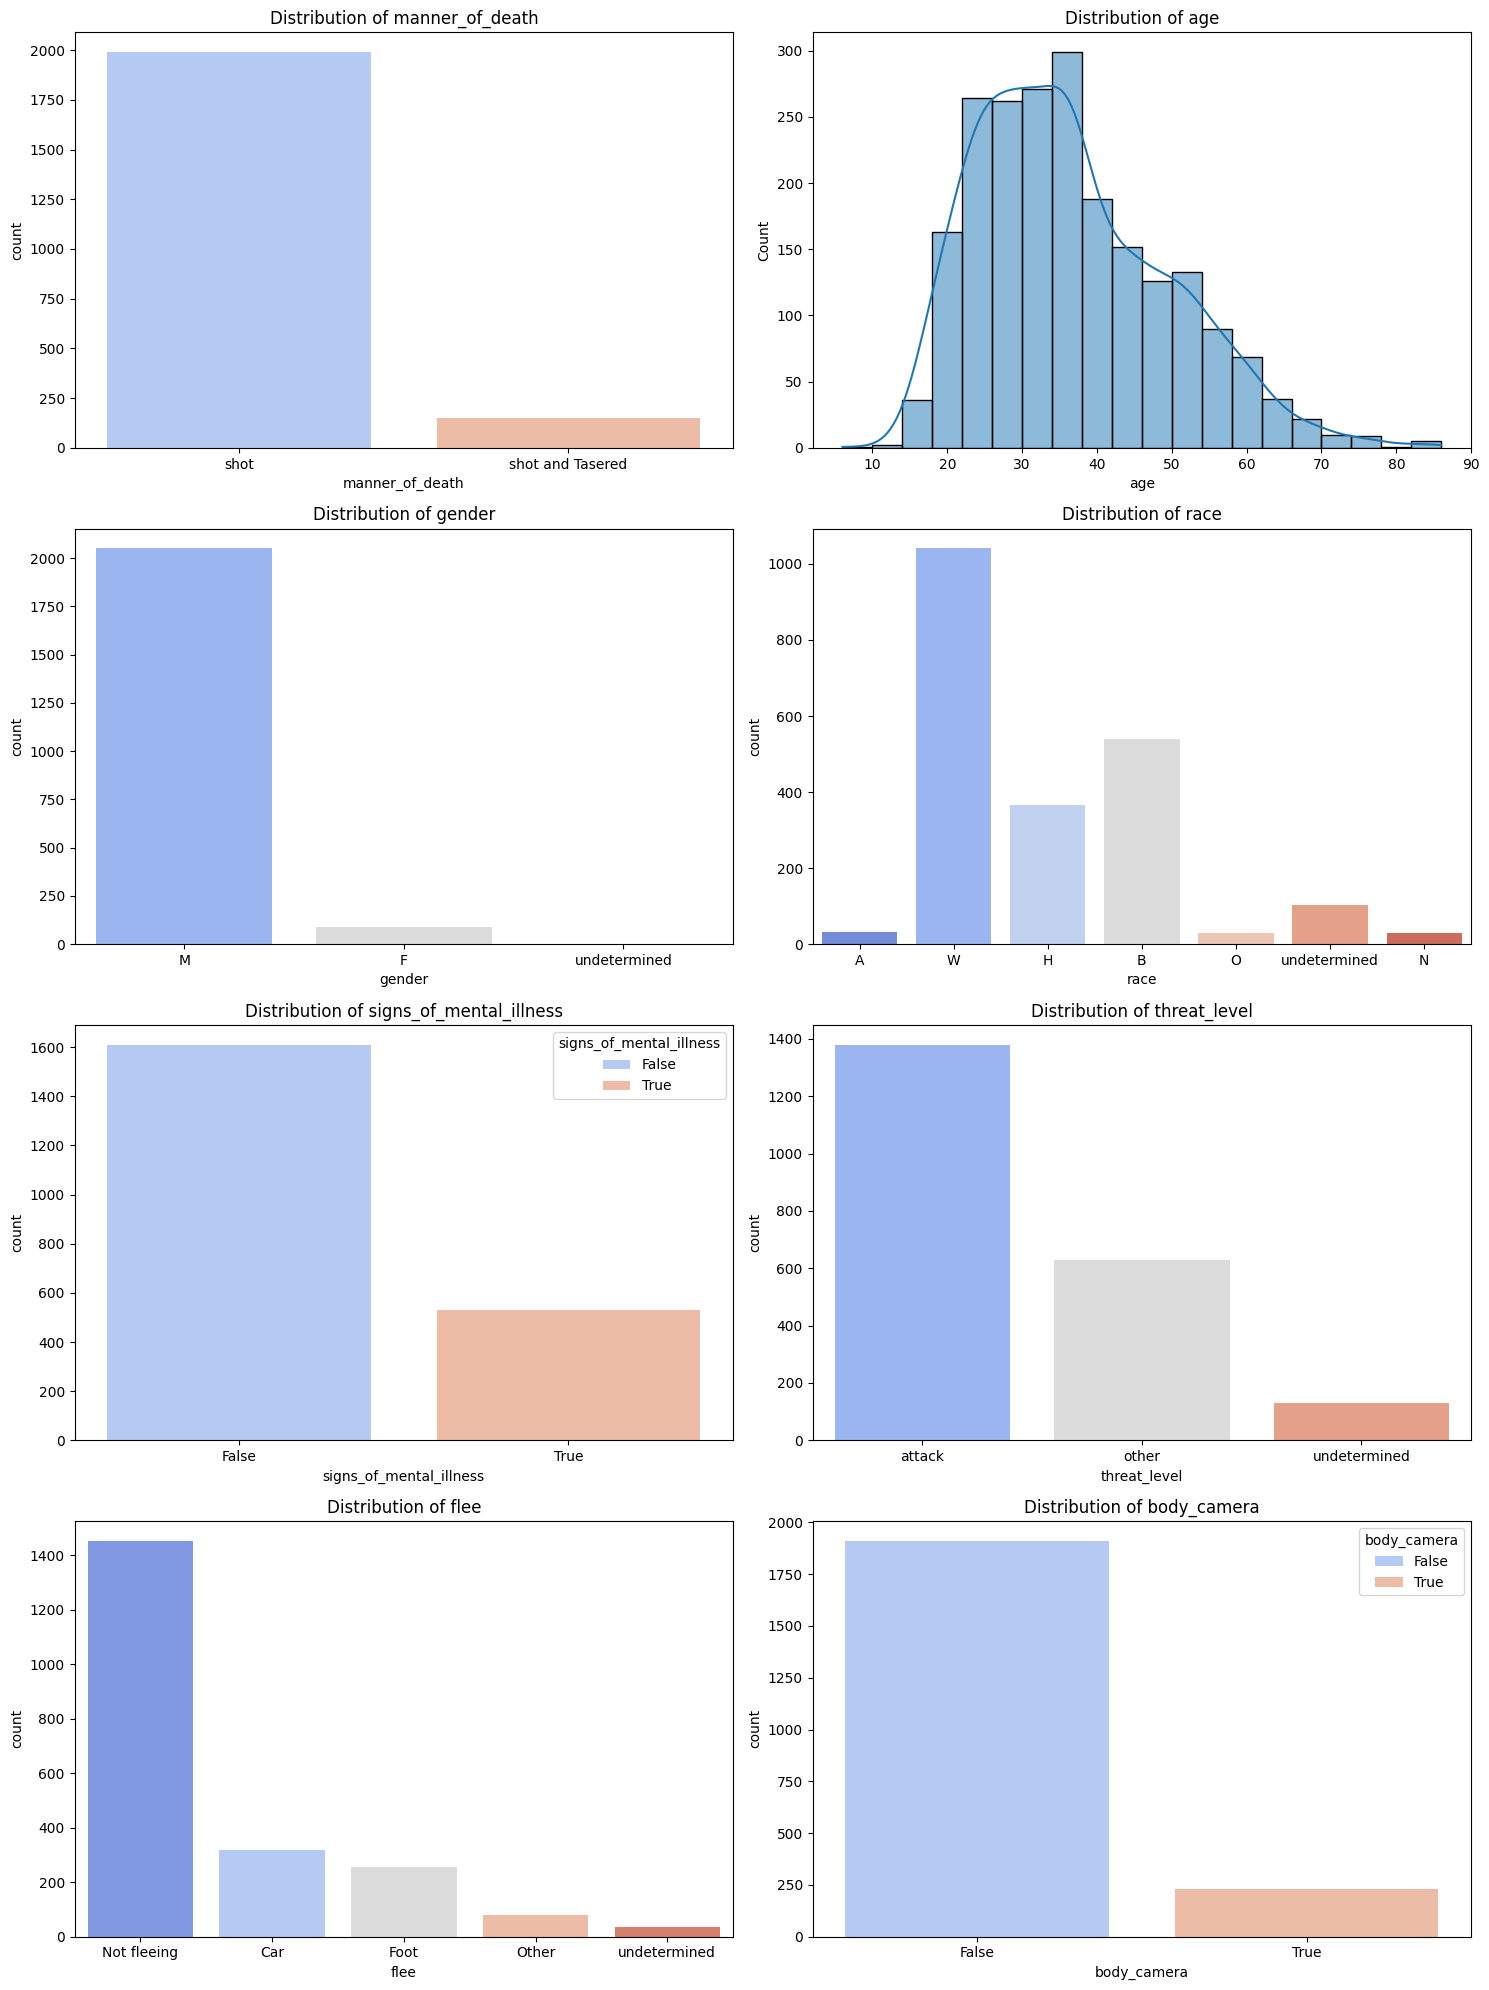

In [34]:
# List of features to plot
features = ['manner_of_death', 'age', 'gender',
            'race', 'signs_of_mental_illness',
            'threat_level', 'flee', 'body_camera']

# List of categorical features
categorical_features = ['manner_of_death', 'gender',
                        'race', 'signs_of_mental_illness',
                        'threat_level', 'flee', 'body_camera']

# List of continuous features
continuous_features = ['age']

# Calculate the number of rows needed for the subplots
n_rows = int(np.ceil(len(features) / 2))

# Create a figure and a 2D array of subplots
fig, axs = plt.subplots(n_rows, 2, figsize=(15, n_rows*5))

# List of continuous features
continuous_features = ['age']

# Flatten the 2D array of subplots into a 1D array
axs = axs.flatten()

# Plot each feature
for i, feature in enumerate(features):
    if feature in categorical_features:
        sns.countplot(data=main_df,
                      x=feature,
                      ax=axs[i],
                      hue=feature,
                      palette="coolwarm")
    elif feature in continuous_features:
        sns.histplot(data=main_df, x=feature, ax=axs[i], kde=True, bins=20)
    axs[i].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

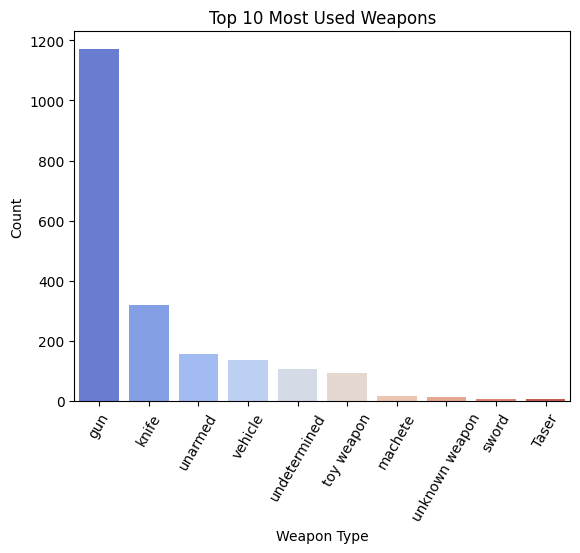

In [35]:
# Get the counts of each weapon
weapon_counts = main_df['armed'].value_counts()

# Get the top 10
top_10_weapons = weapon_counts.head(10)

sns.barplot(x=top_10_weapons.index,
            y=top_10_weapons.values,
            hue=top_10_weapons.index,
            palette='coolwarm')

# Title and labels
plt.title('Top 10 Most Used Weapons')
plt.xlabel('Weapon Type')
plt.xticks(rotation=60)
plt.ylabel('Count')

# Show the plot
plt.show()

In [36]:
# Calculate percentages of each body_camera type
for body_camera_type, count in main_df['body_camera'].value_counts().items():
    percentage = count / len(main_df) * 100
    print(f"{body_camera_type}: {count} ({percentage:.2f}%)")

False: 1911 (89.30%)
True: 229 (10.70%)


# Objective and Analysis goal

Based on the above plots, the analysis will focus on incidents where individuals were fatally shot, specifically targeting male victims of white, hispanic and black races.</br>This examination will exclude cases where signs of mental illness were reported and will prioritize instances where the threat level was identified as an attack and the victim was not fleeing. Moreover, the analysis will encompass situations where police officers did not have body cameras, reflecting the prevailing absence of such technology in nearly 90% of recorded incidents.</br> Also, the most dangerous places are going to be investigated along with mapping of the cities where the incidents occurred, and population.

To further analyze events by year and month, I will extract this data from date and add it to new additional features inside the dataframe.

In [37]:
# Convert the 'date' column to datetime format
main_df['date'] = pd.to_datetime(main_df['date'])

# Extract the year and month
main_df['year'] = main_df['date'].dt.year
main_df['month'] = main_df['date'].dt.month

Below, I will explore the incidents, grouped by year to see the distribution for each.

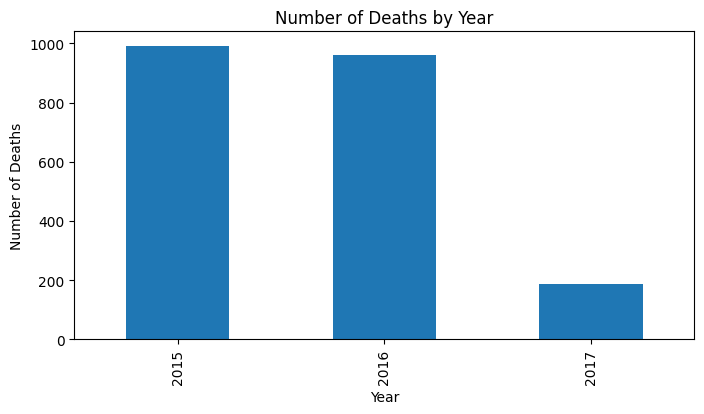

In [38]:
# Extract the year from the 'date' column
main_df['year'] = main_df['date'].dt.year

# Group the data by year and count the number of deaths
deaths_by_year = main_df.groupby('year').size()

# Plot the number of deaths by year
deaths_by_year.plot(kind='bar', edgecolor='none', figsize=(8, 4))
plt.xlabel('Year')
plt.ylabel('Number of Deaths')
plt.title('Number of Deaths by Year')
plt.show()

In [39]:
# Check the dates from 2017
df_2017 = main_df[main_df['date'].dt.year == 2017]
min_date = df_2017['date'].min()
max_date = df_2017['date'].max()
print('Minimum date:', min_date)
print('Maximum date:', max_date)
print('Total of records: ', len(df_2017))

Minimum date: 2017-01-01 00:00:00
Maximum date: 2017-02-28 00:00:00
Total of records:  187


## Data inconsistency finding

As observed, the distribution appears relatively consistent between 2015 and 2016; however, a notable decline is evident in 2017.</br> As the above code shows, for 2017, only 187 events were recorded until 28-02-2017. So the conclusion is that with the lack of data, the events are not entirely showed for 2017.

The following plot aims to explore the distribution of gender among the most targeted racial groups. It reveals a predominant male presence across all three races: White, Black, and Hispanic.

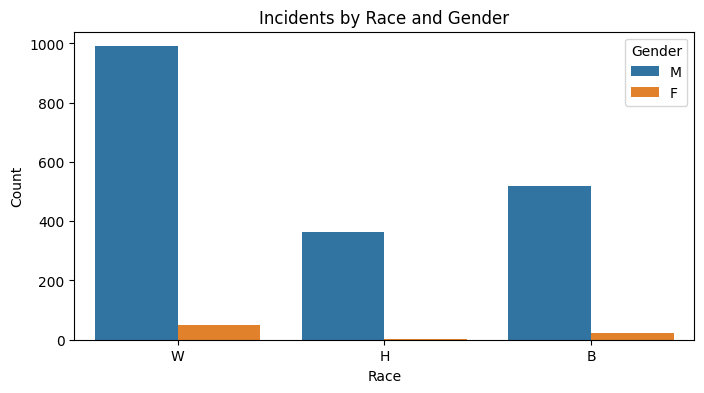

In [40]:
# Filter the DataFrame to include only the specified races
filtered_df = main_df[main_df['race'].isin(['W', 'B', 'H'])]

# Create a count plot of the races, segmented by gender
plt.figure(figsize=(8, 4))
sns.countplot(data=filtered_df, x='race', edgecolor='none', hue='gender')
plt.title('Incidents by Race and Gender')
plt.xlabel('Race')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()

# Demographic analysis: Racial group

In [41]:
# Calculate the total number of events
total_events = len(main_df)

# Calculate the total for each race
race_filter = main_df['race'].isin(['W', 'B', 'H'])
race_totals = main_df[race_filter]['race'].value_counts()

# Calculate the percentages
race_percentages = race_totals / total_events * 100

# Print the totals and percentages
print(f"Total events: {total_events}")
for race, total in race_totals.items():
    print(f"Total for {race}: {total} ({race_percentages[race]:.2f}%)")

Total events: 2140
Total for W: 1041 (48.64%)
Total for B: 540 (25.23%)
Total for H: 367 (17.15%)


It's evident that 91% of the victims are from the white, black, and hispanic racial groups. Among these groups, black and Hispanic individuals tend to be the youngest casualties, followed by Native Americans. Additionally for the white, black, and hispanic racial groups also have a higher number of outliers, indicating victims with ages beyond the usual range observed in the dataset.

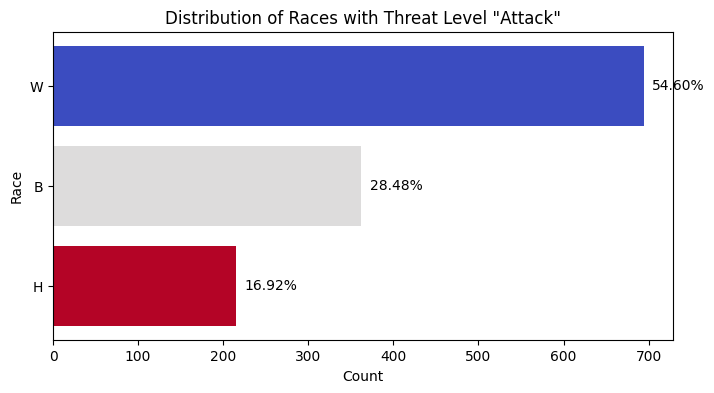

In [42]:
import matplotlib.cm as cm

# # Calculate the distribution of races with threat level "Attack"
filtered_df_attack = filtered_df[filtered_df['threat_level'] == 'attack']
race_distribution_attack = filtered_df_attack['race'].value_counts()

# Calculate the percentages
race_percentages_attack = (race_distribution_attack /
                           race_distribution_attack.sum() * 100
                           )

# Create a horizontal bar plot with a color gradient
colors = cm.coolwarm(np.linspace(0, 1, len(race_distribution_attack)))
plt.figure(figsize=(8, 4))  # Create a new figure
plt.barh(race_distribution_attack.index,
         race_distribution_attack,
         color=colors)
plt.title('Distribution of Races with Threat Level "Attack"')
plt.xlabel('Count')
plt.ylabel('Race')
plt.gca().invert_yaxis()  # Invert the y-axis

# Print the percentages on the plot
for i, race in enumerate(race_distribution_attack.index):
    percentage = race_percentages_attack[race]
    plt.text(race_distribution_attack[race] + 10, i,
             f'{percentage:.2f}%',
             va='center')

plt.show()

In [43]:
print("Race distirbution by threat level 'Attack' are :",
      race_distribution_attack)
print("Total of threat level 'Attack' for these racial groups: ",
      race_distribution_attack.sum())
percentage = (race_distribution_attack.sum() / len(main_df)) * 100
print("The percentage of 'attack' incidents involving the races 'W', "
      f"'B', or 'H' is {percentage:.2f}%")

Race distirbution by threat level 'Attack' are : race
W    694
B    362
H    215
Name: count, dtype: int64
Total of threat level 'Attack' for these racial groups:  1271
The percentage of 'attack' incidents involving the races 'W', 'B', or 'H' is 59.39%


Taking into account the combined racial categories of white, black, and Hispanic individuals, it's evident that more than 59% of the attacks originate from this demographic.</br>As illustrated in the subsequent plots, within this demographic, 91% of incidents occurred without the use of police body cameras. This aligns with the broader pattern observed across all cases, previsously showed, where 89.30% of incidents lacked recorded footage from body cameras.</br>This observation prompts inquiries into how law enforcement determined the presence or type of weapons wielded by victims, if any.

In [44]:
# Filter the DataFrame to include only the specified races and threat level
race_filter = main_df['race'].isin(['W', 'B', 'H'])
attack_df = main_df[race_filter & (main_df['threat_level'] == 'attack')]

# Calculate the distribution of body camera usage
body_camera_distribution = attack_df['body_camera'].value_counts()

print(body_camera_distribution)

body_camera
False    1155
True      116
Name: count, dtype: int64


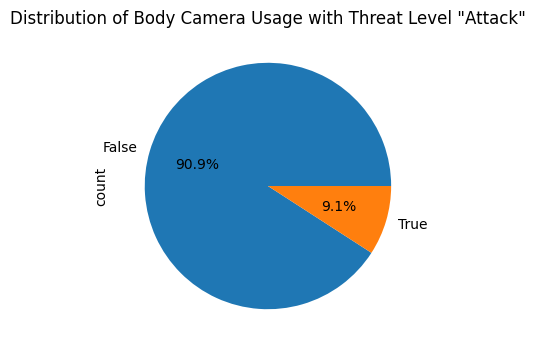

In [45]:
# Create a pie chart of the body camera usage distribution
body_camera_distribution.plot(kind='pie', figsize=(6, 4), autopct='%1.1f%%')

# Set the title of the plot
plt.title('Distribution of Body Camera Usage with Threat Level "Attack"')

# Show the plot
plt.show()

# Exploring events locations

Now, I want to explore the 10 most dangerous cities within the dataset.

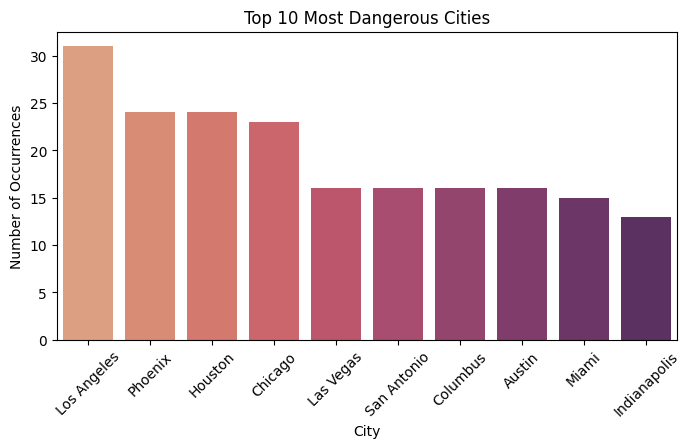

In [46]:
# Count the number of occurrences in each city
city_counts = main_df['city'].value_counts()

# Select the top 10 cities with the most occurrences
top_10_dangerous_cities = city_counts.nlargest(10)

# Create a DataFrame from the Series
df = top_10_dangerous_cities.reset_index()
df.columns = ['City', 'Number of Occurrences']

# Plot the top 10 most dangerous cities
plt.figure(figsize=(8, 4))
sns.barplot(x='City',
            y='Number of Occurrences',
            hue='City',
            legend=False,
            data=df,
            dodge=False,
            palette="flare")
plt.title('Top 10 Most Dangerous Cities')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.ylabel('Number of Occurrences')

plt.show()

Now we will take a look over states and overall USA, to see the events in a more distributed way.

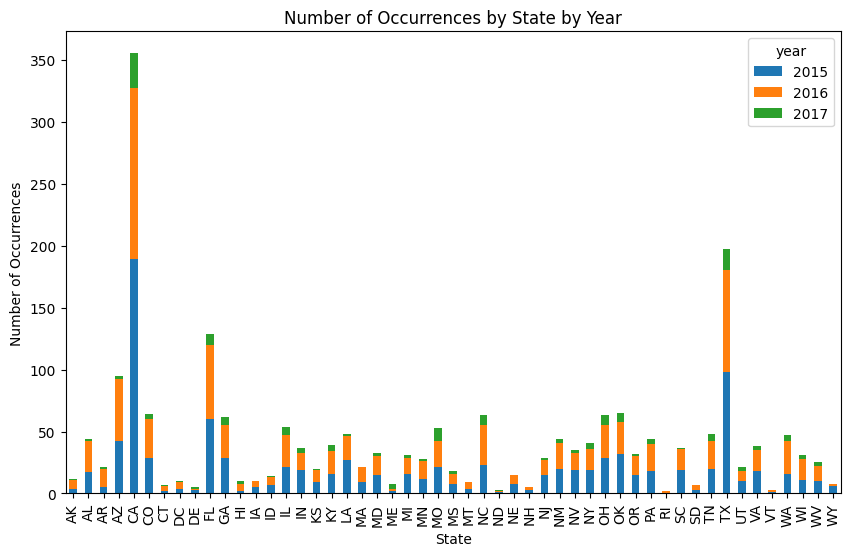

In [47]:
# Group the data by year and state and count the number of occurrences
occurrences_by_year_state = main_df.groupby(
    ['year', 'state']).size()

# Unstack the data for plotting
occurrences_by_year_state_unstacked = (
    occurrences_by_year_state.unstack(level=0)
    )

# Plot the number of occurrences for each state for each year
occurrences_by_year_state_unstacked.plot(
    kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('State')
plt.ylabel('Number of Occurrences')
plt.title('Number of Occurrences by State by Year')
plt.show()

Since github does render images, an image of the following code is placed here:</br>


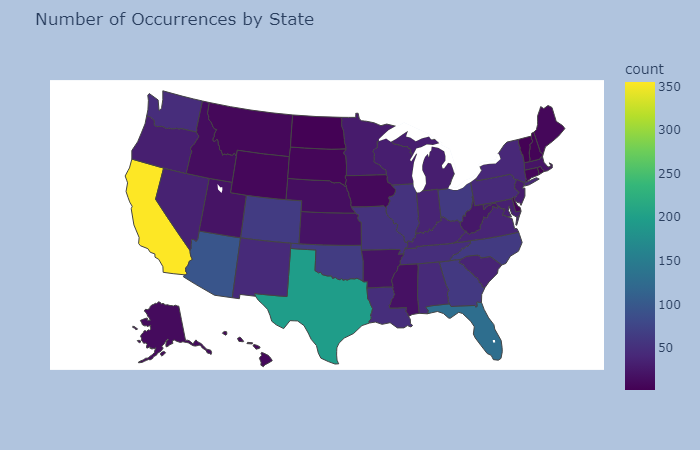
 
We can see, confirming the above plot, that California, Texas and Florida are the ones with the highest number of occurences, followed by Arizona.

In [ ]:
# Count the number of occurrences for each state
state_counts = main_df['state'].value_counts().reset_index()
state_counts.columns = ['state', 'count']

# Create a choropleth map
fig = px.choropleth(state_counts,
                    locations='state',
                    locationmode="USA-states",
                    color='count',
                    hover_name='state',
                    color_continuous_scale="Viridis",
                    title='Number of Occurrences by State',
                    scope='usa')

# Adjust the map's margins (top, bottom, left, right)
fig.update_layout(
    autosize=False,
    margin=dict(t=50, b=50, l=50, r=50),
    paper_bgcolor="LightSteelBlue",
    uirevision='constant'  # preserve user's interactions
)

fig.show()

As to further investigating the events by location, the usage of latitude and longitues are usefull to have a more precise understanding of the cities where the incidents occured.</br> An additional dataset will be used, that can be merged into our analysis to include the regions. This wil ease the visualization by regions. The code below will add the state_id column (since it is missing from the dataset), and then merge with the main dataset, currently being used in the analysis.

In [49]:
state_ids = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

for state_name, state_id in state_ids.items():
    us_pop_df.loc[us_pop_df['name'] == state_name, 'state_id'] = state_id

In [50]:
us_pop_df.head()

,region,state,name,sex,age,pop2015,pop2016,pop2017,state_id
348,3,1,Alabama,1,0,30028,29856,29701,AL
349,3,1,Alabama,1,1,29846,30152,29940,AL
350,3,1,Alabama,1,2,29463,30047,30298,AL
351,3,1,Alabama,1,3,29896,29530,30103,AL
352,3,1,Alabama,1,4,30557,29903,29636,AL


This merge will add the regions to the main dataframe.

In [51]:
us_pop_region_df = (
    us_pop_df.groupby('state_id')['region']
    .first()
    .reset_index()
)
# Set 'state_id' as the index of us_pop_region_df for the merge
us_pop_region_df.set_index('state_id', inplace=True)

main_df = main_df.merge(
    us_pop_region_df,
    left_on='state',
    right_index=True,
    how='left',
    validate="many_to_many")

# Geographical US map with event locations

Since gihub does not render images, the below map can be viewed by accessing the link [here](https://fachapuis.github.io/ds_web/events_region_usa.html).</br>
To interpret the colors in this map, it just needed to associate the colors like the table below:
| Region    | Color                                    |
| --------- | ---------------------------------------- |
| Northeast | <span style="color:Green">Green</span>   |
| Midwest   | <span style="color:Yellow">Yellow</span> |
| South     | <span style="color:Orange">Orange</span> |
| West      | <span style="color:Red">Red</span>       |

In [ ]:
# Create a map centered on the United States
map = folium.Map(location=[44.582480, -103.529343],
                 zoom_start=2,
                 min_zoom=3,
                 max_zoom=15)
map.get_root().html.add_child(
    folium.Element('<h3 style="text-align:center; color:blue;">'
                   'Police Shootings Locations by Region</h3>')
)

# Color scale for the regions
color_scale = folium.StepColormap(
    colors=['green', 'yellow', 'orange', 'red'],
    vmin=1,
    vmax=4,
    caption='Region'
)

# Add the color scale to the map
map.add_child(color_scale)

# Dictionary to map region numbers to names
region_numbers = {'Northeast': 1, 'Midwest': 2, 'South': 3, 'West': 4}
number_regions = {1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West'}

# Iterate over the rows of main_df_regions
for index, row in main_df.iterrows():
    # Get the state, city and region values
    state = row['state']
    city = row['city']
    region = row['region']

    # Latitude and longitude of the state
    latitude = row['latitude']
    longitude = row['longitude']

    # Check if the region exists in the dictionary before trying to access it
    if region in number_regions:
        color = color_scale(region)
    else:
        print(f"Region {region} not found in region_numbers dictionary.")

    # Define the marker
    marker = folium.CircleMarker(location=[latitude, longitude],
                                 radius=5,
                                 color=color,
                                 fill=True,
                                 fill_color=color,
                                 fill_opacity=0.6,
                                 tooltip=f"{city}, {state}")

    # Add the marker to the map
    marker.add_to(map)

# Display the map
map

# Save the map as an HTML file
# map.save('./assets/data/image/events_region_usa.html')

# Targeted racial groups by regions

As we can see, the distribution of the racial groups by region shows the impact for each race.</br> Even having California (from West region) as most dangerous city, overall, the South leads the majority of events.</br>
From the four regions in US, South and West have 76% of all the events being the South, with more events.

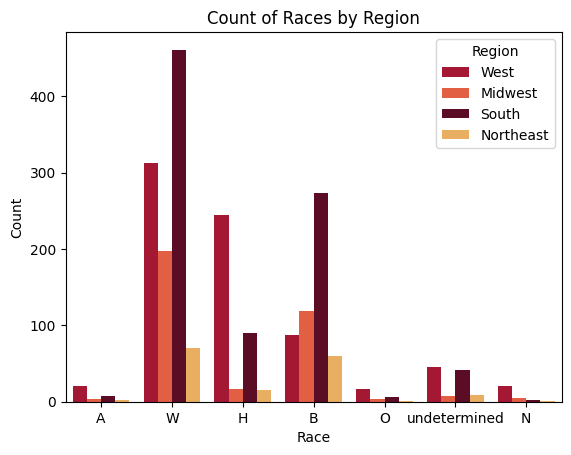

In [53]:
# Fill missing values in the 'region' column with a default value
main_df['region'] = main_df['region'].fillna('Unknown')

# Define a dictionary to map region numbers to names
region_dict = {1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West'}

# Replace the numeric values in the 'region' column
main_df['region'] = main_df['region'].replace(region_dict)

# Define a dictionary to map region names to colors
color_dict = {'Northeast': '#FEB24C',
              'Midwest': '#FC4E2A',
              'South': '#67001F',
              'West': '#BD0026',
              'Unknown': '#808080'}  # color for the 'Unknown' region

# Fill missing values in the 'region' column with a default value
main_df['region'] = main_df['region'].fillna('Unknown')

# Create a list of colors for the regions in the same order
colors = main_df['region'].map(color_dict)

# Now you can create your plot with the custom colors
sns.countplot(data=main_df,
              x='race',
              hue='region',
              palette=color_dict)
plt.title('Count of Races by Region')
plt.xlabel('Race')
plt.ylabel('Count')
plt.legend(title='Region')
plt.show()

Interesting to see in this plot that the Hispanic race is more threatened in the West than other races, different for Black and White, that follows the highest threat level in the South. And that pattern is also seen for Asians, Natives, Other and Undertemined races.

In [54]:
# Group the DataFrame by 'race' and 'region' and count the number of events
event_counts = main_df.groupby(
    ['race', 'region']
    ).size().reset_index(name='count')
# Sort the DataFrame by 'count' in descending order and get the first 10 rows
top_10_event_counts = event_counts.sort_values(
    by='count', ascending=False
    ).head(10)

# Print the event counts
print(top_10_event_counts)

   race     region  count
22    W      South    461
23    W       West    312
6     B      South    274
11    H       West    244
20    W    Midwest    197
4     B    Midwest    119
10    H      South     90
7     B       West     87
21    W  Northeast     71
5     B  Northeast     60


In [55]:
# Count the total number of events for regions
region_counts = main_df[main_df['region'].isin(['South',
                                                'West',
                                                'Midwest',
                                                'Northeast'])]
region_counts = region_counts.groupby('region').size()

# Count the total number of unique IDs in min_df
total_ids = main_df.index.nunique()

# Divide the region counts by the total number of unique IDs
region_counts_normalized = round(region_counts / total_ids * 100, 2)

# Print the normalized region counts
print(region_counts_normalized)

region
Midwest      16.45
Northeast     7.48
South        41.21
West         34.86
dtype: float64


# 'Age' feature and group analysis

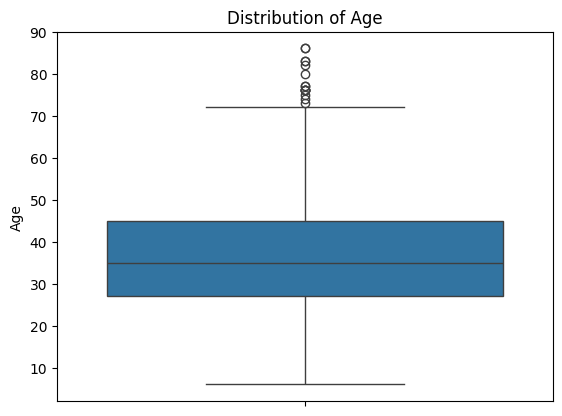

In [56]:
sns.boxplot(y=main_df['age'])
plt.title('Distribution of Age')
plt.ylabel('Age')
plt.show()

Some outliers can be seen according to the above plot. </br> Below we will plot the races and ages distribution to see if we can spot any trends for the events, by correlating these two features and understand more about he data distribution, outliers and averages.

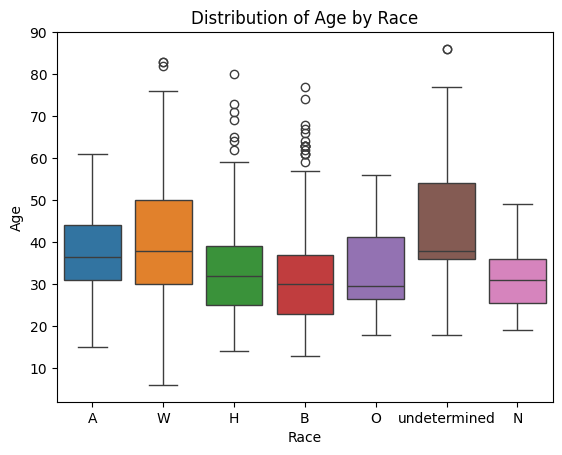

In [57]:
sns.boxplot(x='race', y='age', hue='race', data=main_df)
plt.title('Distribution of Age by Race')
plt.xlabel('Race')
plt.ylabel('Age')
plt.show()

The mean age of the overall population is ~ 36.5, but when looking at specific racial and ethnic groups such as Hispanic, Black, Native, and others, the average age is around 30 years.</br>Interesting to see the Black race, they tend to be killed younger and also have the majority of outliers, from the total races.</br> As to investigate the events, the following analysis will take age groups being compared to the populations of each state.

In [58]:
# Filter the data for individuals who are over 25 and armed
total_population = len(main_df)
over_25_armed = main_df.loc[(main_df['age'] >= 25)]
under_25_armed = main_df.loc[(main_df['age'] < 25)]

# Count the number of rows
num_over_25_armed = over_25_armed.shape[0]
num_under_25_armed = under_25_armed.shape[0]

# Percentage calculation
over_25_armed_percentage = round(
    num_over_25_armed / total_population * 100, 2)
under_25_armed_percentage = round(
    num_under_25_armed / total_population * 100, 2)

print("The total of individuals over 25 armed: ", num_over_25_armed)
print("The total of individuals under 25 armed: ", num_under_25_armed)
print("Percentage of over 25 armed: ", over_25_armed_percentage)
print("Percentage of under 25 armed: ", under_25_armed_percentage)

The total of individuals over 25 armed:  1759
The total of individuals under 25 armed:  381
Percentage of over 25 armed:  82.2
Percentage of under 25 armed:  17.8


In [59]:
main_df.describe().round(2)

,date,age,latitude,longitude,year,month
count,2140,2140.00,2140.00,2140.00,2140.00,2140.00
mean,2016-02-01 05:27:42.056075008,36.50,36.63,-97.10,2015.62,6.06
min,2015-01-02 00:00:00,6.00,19.62,-157.94,2015.00,1.00
25%,2015-07-18 18:00:00,27.00,33.45,-112.07,2015.00,3.00
50%,2016-01-31 00:00:00,35.00,36.14,-94.38,2016.00,6.00
75%,2016-08-16 06:00:00,45.00,39.94,-83.00,2016.00,9.00
max,2017-02-28 00:00:00,86.00,71.39,-68.02,2017.00,12.00
std,NaN,12.74,5.25,16.68,0.64,3.58


I decided to group the ages, using equal-widht bins, to better understand the distribution of the ages of the victims. Since the standard deviation is ~ 13, I decided to use bins of 20 years, since using 10 data would be much spreaded.</br>Also, the quartile approach could be used, however it would have the data equaly distributed and I decided to show the distribution with more consitent intervals, regardless the distribution. Also, the quartile approach can be influenced by extreme values.
Since the ages goes from 6 to 86, the groups will distributed as below.
|Age           |Group         |
| ------------ | -------------|
| 6 -> 25      | Young        |
| 26 -> 45     | Adult        |
| 46 -> 65     | Middle-Aged  |
| 66 -> 86     | Senior       |

In [60]:
main_df['age_group'] = main_df['age'].apply(classify_age_bins)
main_df.head()

,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,latitude,longitude,year,month,region,age_group
id,,,,,,,,,,,,,,,,,,,
3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,47.215094,-123.100706,2015,1,West,Middle-aged
4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,45.491518,-122.869420,2015,1,West,Middle-aged
5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,37.692236,-97.337545,2015,1,Midwest,Young
8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,37.779259,-122.419329,2015,1,West,Adult
9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,40.377217,-104.697763,2015,1,West,Adult


In [61]:
us_pop_df['age_group'] = us_pop_df['age'].apply(classify_age_bins)
us_pop_df.head()

,region,state,name,sex,age,pop2015,pop2016,pop2017,state_id,age_group
348,3,1,Alabama,1,0,30028,29856,29701,AL,not grouped
349,3,1,Alabama,1,1,29846,30152,29940,AL,not grouped
350,3,1,Alabama,1,2,29463,30047,30298,AL,not grouped
351,3,1,Alabama,1,3,29896,29530,30103,AL,not grouped
352,3,1,Alabama,1,4,30557,29903,29636,AL,not grouped


Below we can see how is distributed the individuals into the defined age groups previously mentioned.

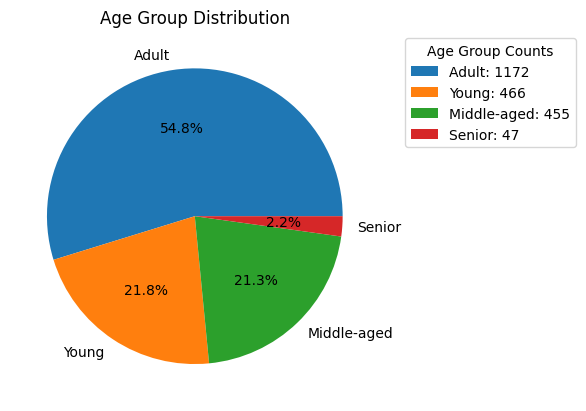

In [62]:
# Calculate value counts
age_group_counts = main_df['age_group'].value_counts()

# Get labels from the index of the Series
labels = age_group_counts.index

# Get sizes from the values of the Series
sizes = age_group_counts.values

# Create pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')

# Add values to the legend
legend_labels = [f'{label}: {size}' for label, size in zip(labels, sizes)]
plt.legend(title='Age Group Counts',
           labels=legend_labels,
           bbox_to_anchor=(1.05, 1),
           loc=2)

ax.title.set_text('Age Group Distribution')
plt.show()

### Analysis for top 3 most dangerous States by age group - 2015 to 2017

As already mentioned in the **Dependencies** topic inside the `README.md` file, some functions developed will be used in this part of the analysis.</br>
In a nutshel they were devolped to get data from a range of years (in this case from 2015 to 2017), along with pre-defined USA states, the three most dangerous ones (CA, TX and AZ) and also the age groups defined, in this case the most targeted ones (Adults, Middle-Aged and Youngs). Then other functions will group these data and plot it out.</br>
The last function `process_year_data` is used to call all the previous functions together.</br>
The analysis will be carried on for the age groups, and the distribution of the events for each state, so then we can compare the beahviour for each state, age group and years, all together.

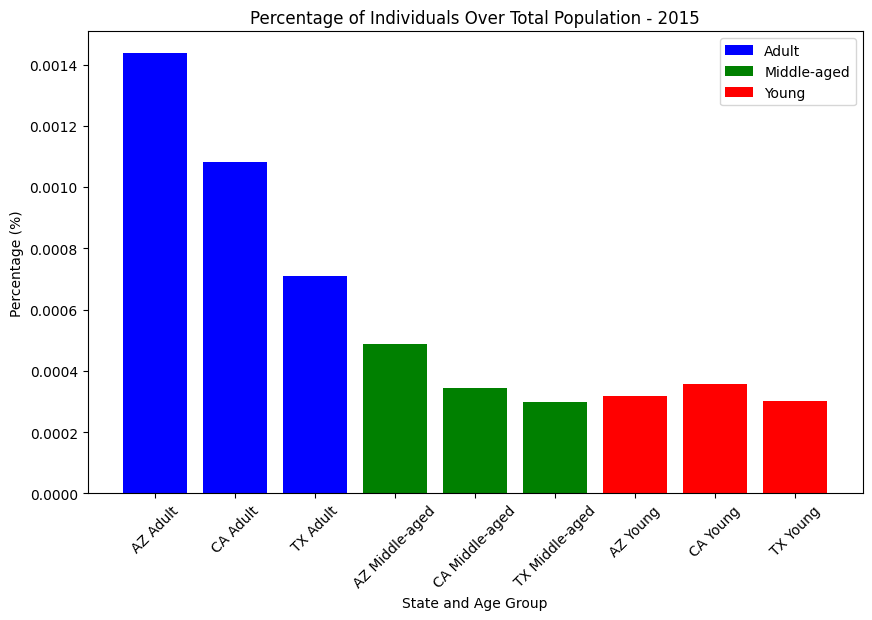

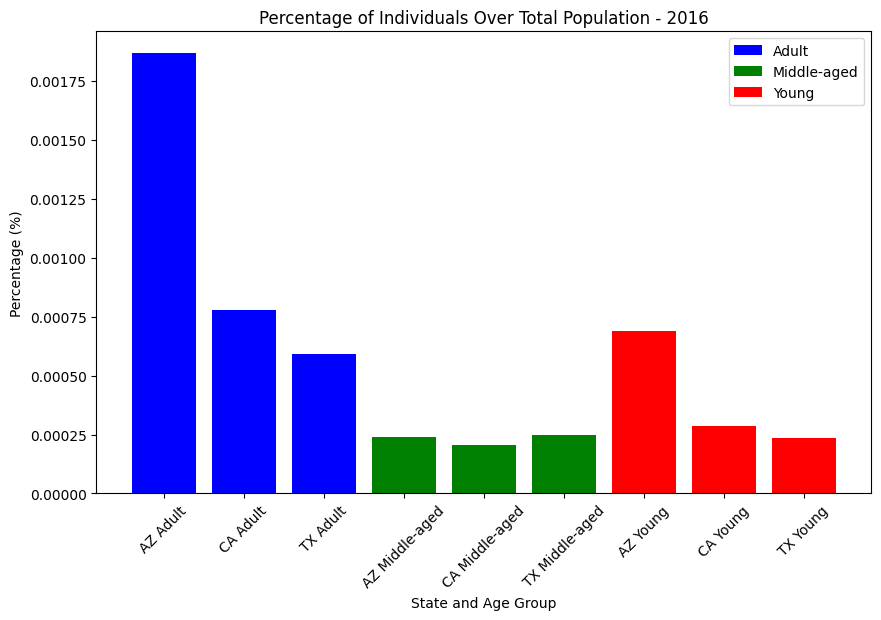

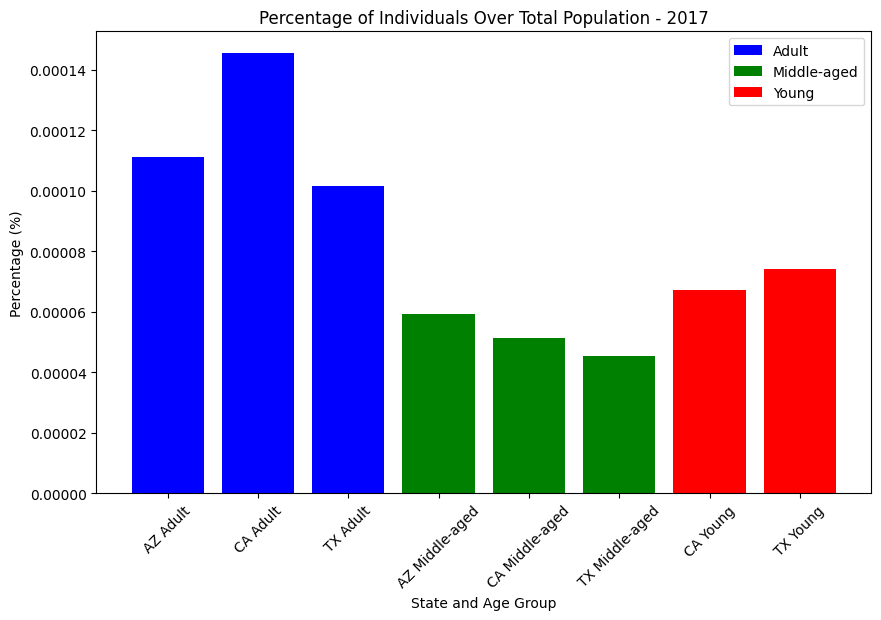

In [63]:
for year in range(2015, 2018):
    process_year_data(main_df, us_pop_df, year)

Just recaping, for this analysis we are considering the age group distibution for Young, Adults and Middle-Aged as this:
|Age           |Group         |
| ------------ | -------------|
| 6 -> 25      | Young        |
| 26 -> 45     | Adult        |
| 46 -> 65     | Middle-Aged  |

If we consider the total population for each state in these years, the highest percentage is around 0.175 for adults in Arizona in 2016. By looking at the results from 2015, it is notable that the incidents with adults are more frequent.</br>However, there is a considerable number of events occurred to the young population, even higher compared with Middle-aged, if we check the data from 2016. This is a significant finding, as it indicates that the young population is more vulnerable to these events, especially in Arizona and California.

# EDA Conclusion

1. **Focus on Fatal Incidents and Specific Demographics:**</br>
The analysis primarily focuses on incidents involving fatal shootings, specifically targeting male victims of white, Hispanic, and black races.
Cases involving mental illness, fleeing victims, and incidents where the threat level was not an attack are excluded from the examination.
2. **Absence of Body Cameras:**</br>
Nearly 90% of recorded incidents lack police body camera footage, highlighting the prevalent absence of this technology in law enforcement encounters.
3. **Racial Distribution and Age Groups:**</br>
White, black, and Hispanic racial groups account for 91% of the victims, with black and Hispanic individuals tending to be the youngest casualties.
Outliers in age distribution are observed within these racial groups, indicating victims with ages beyond the usual range.
4. **Demographic Analysis:**</br>
More than 59% of attacks originate from the combined racial categories of white, black, and Hispanic individuals.
The majority of incidents within this demographic occur without the use of police body cameras, raising questions about weapon identification by law enforcement.
5. **Regional Impact and Dangerous Cities:**</br>
The South and West regions lead in the number of events, with California identified as the most dangerous city in the West region.
The distribution of racial groups by region highlights the impact of each race, with the South experiencing a higher number of events.
6. **Age Group Analysis:**</br>
Age groups were categorized using equal-width bins to better understand the age distribution of victims, considering a bin width of 20 years for consistency.
7. **Analysis of Top 3 Most Dangerous States by Age Group - 2015:**</br>
Arizona and California show a higher percentage of incidents involving adults, indicating a higher frequency of events in these age groups.
The young population, particularly in Arizona and California, is vulnerable to these events, with a considerable number of incidents reported compared to other age groups.
8. **Overall**</br>The analysis provides valuable insights into the demographics, regional impact, age distribution, and prevalence of incidents without body camera footage, shedding light on key factors influencing fatal shootings and law enforcement encounters.

# Project Conclusion
Overal I think it was a good outcome.
Working along different dataset is quite interesting and enrichment process for learning and exploring different approaches.</br>
The approach of using a new dataset, due to the use of Geopy requiring too much time to get latitudes and longitudes was a good learning. Not only to avoid this loading time but also to not change the original data.
Although I haven't explored more concepts about data analysis such as clustering, machine learning and others, the reason is the lack of further knowledge and time constraint.</br>
Also, the functions created can be refactored and improved to be more efficient and reusable, which is a good learning for future projects.</br>Some coding, such as the mappings and others can be used as functions as well.</br>